In [2]:
import skimage.io
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path
from PIL import Image 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [3]:
PATH = Path("../data")

In [4]:
#labels = pd.read_csv(PATH/'train_labels.csv')
test = pd.read_csv(PATH/'test.csv')
labels = pd.read_csv(PATH/'train_labels_clean.csv')
labels.head(3)

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4


In [5]:
X_train, X_val, y_train, y_val = train_test_split(labels['image_id'].values, 
                                                  labels['isup_grade'].values, test_size=0.2, random_state=42)

In [6]:
def read_file(filename):
    '''return array representing image'''
    return skimage.io.imread(PATH/f'train/{filename}')


In [7]:
def read_file_bw(filename):
    image_file = Image.open(PATH/f'train/{filename}') # open colour image
    image_file = image_file.convert('1') # convert image to black and white
    return image_file

In [8]:
def get_mask(filename):
    return skimage.io.imread(PATH/f'masks/{filename}')

In [9]:
class PANDADataset(Dataset):
    def __init__(self, X, y):
        files = []
        for i in range(len(X)):
            files.append(np.concatenate(np.array([read_file(X[i] + '_' + str(j) + '.png') 
                          for j in range(16)])))
        self.x = files
        
        masks = []
        for i in range(len(X)):
            masks.append(np.concatenate(np.array([get_mask(X[i] + '_' + str(j) + '.png') 
                          for j in range(16)])))
        self.y = masks
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
train_ds = PANDADataset(X_train, y_train)
valid_ds = PANDADataset(X_val, y_val)

In [10]:
train_dl = DataLoader(train_ds, batch_size=1, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=1)

In [11]:
# should be (batch_size, channel, height, width)

In [12]:
x, y = next(iter(train_dl))
x = torch.tensor(x).float()

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [13]:
x = x.view(1,3,2048,128)

In [17]:
y.shape

torch.Size([1, 2048, 128])

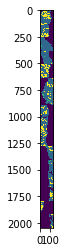

In [22]:
plt.imshow(y.squeeze(0).cpu())

In [39]:
dconv_down1 = double_conv(3, 64)
x = dconv_down1(x)
x.shape

torch.Size([1, 64, 2048, 128])

In [40]:
maxpool = nn.MaxPool2d(2)
x = maxpool(x)
x.shape

torch.Size([1, 64, 1024, 64])

In [41]:
dconv_down2 = double_conv(64, 128)
x = dconv_down2(x)
x.shape

torch.Size([1, 128, 1024, 64])

In [42]:
x = maxpool(x)
x.shape

torch.Size([1, 128, 512, 32])

In [43]:
# code from https://github.com/usuyama/pytorch-unet/blob/master/pytorch_unet.py

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        #self.fc = nn.Linear(n_class, 1)
        
        
    def forward(self, x):
        x = x.float().cuda()
        x = x.view(1,3,2048,128) #batch size, channels, height, width
        
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

In [44]:
def valid_metrics(model):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    for x, y in valid_dl:
        x = x.long().cuda()
        y = y.long().cuda()
        batch = y.shape[0]
        out = model(x)
        loss = F.cross_entropy(out, y)
        sum_loss += batch*(loss.item())
        total += batch
        pred = torch.argmax(out, axis=1).float()
        correct += (pred == y).float().sum().item()
    val_loss = sum_loss/total
    val_acc = correct/total
    return val_loss, val_acc

In [45]:
def train_epocs(model, optimizer, epochs=10):
    for i in range(epochs):
        model.train()
        total_loss = 0
        total = 0
        for x, y in train_dl:
            x = x.long().cuda()
            y = y.long().cuda()
            out = model(x)
            #plt.imshow(x.squeeze(0).cpu())
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += x.size(0)*loss.item()
            total += x.size(0)
        train_loss = total_loss/total
        val_loss, val_accuracy = valid_metrics(model)
        
        print("train_loss %.3f val_loss %.3f val_accuracy %.3f" % (
            train_loss, val_loss, val_accuracy))

In [46]:
model = UNet(6).cuda()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_epocs(model, optimizer, epochs=5)

train_loss 90744390728267137024.000 val_loss 0.944 val_accuracy 164428.027
